**Task 2:** Image classification using a CNN with CL1, PL1, CL2 and PL2 as the layers. Use 
kernels of size 3x3, stride of 1 in the convolutional layers. Use the mean pooling with a 
kernel size of 2x2 and stride of 2 in the pooling layers. Use 4 feature maps in CL1. The 
number of feature maps in CL2 is a hyperparameter.


In [ ]:
# Image classification using a CNN with CL1, PL1, CL2 and PL2 as the layers. Use 
# kernels of size 3x3, stride of 1 in the convolutional layers. Use the mean pooling with a 
# kernel size of 2x2 and stride of 2 in the pooling layers. Use 4 feature maps in CL1. The 
# number of feature maps in CL2 is a hyperparameter.

In [3]:
# from google.colab import drive
# drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
import os
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


In [5]:
os.makedirs('plots/Q2', exist_ok=True)
os.makedirs('models/Q2', exist_ok=True)

In [6]:
import zipfile

# Replace 'file_name.zip' with the name of your zip file
zip_file_path = '/content/gdrive/MyDrive/Colab Notebooks/classification.zip'

extract_to_path = '/content/dataset/'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

In [7]:
# Load dataset

# Normalize the image data to have mean 0 and standard deviation 1
# Resize the image to 224x224
# Convert the image to tensor
# Create a DataLoader for the dataset
# Use a batch size of 32
# Shuffle the dataset

data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.ImageFolder(root='./dataset/classification/train', transform=data_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataset = datasets.ImageFolder(root='./dataset/classification/valid', transform=data_transform)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True)
test_dataset = datasets.ImageFolder(root='./dataset/classification/test', transform=data_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [8]:
len(train_dataset.classes)

5

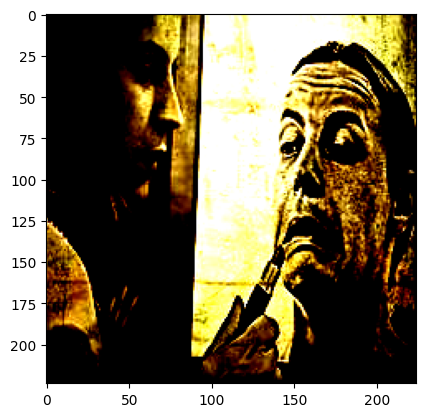

In [9]:
import matplotlib.pyplot as plt
plt.imshow(train_loader.dataset[1000][0].permute(1, 2, 0))
plt.show()

## Image Classification using MLFFNN

In [10]:
class ImageClassification:
    def __init__(self, model, criterion, optimizer):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.train_losses = []
        self.train_accuracies = []
        self.valid_losses = []
        self.valid_accuracies = []

    def train(self, train_loader, valid_loader, num_epochs=5):
        for epoch in range(num_epochs):
            tqdm_train_loader = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
            self.model.train()
            running_loss = 0.0
            correct = 0
            total = 0
            for i, (images, labels) in enumerate(tqdm_train_loader):
                images, labels = images.to(device), labels.to(device)
                self.optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()
                predicted = torch.argmax(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                tqdm_train_loader.set_postfix({'Running Loss': running_loss / (i + 1)})
                tqdm_train_loader.set_description(f"Epoch {epoch+1}/{num_epochs}")

            train_loss = running_loss / len(train_loader)
            train_accuracy = correct / total
            valid_loss, val_accuracy = self.evaluate(valid_loader)
            self.train_losses.append(train_loss)
            self.train_accuracies.append(train_accuracy)
            self.valid_losses.append(valid_loss)
            self.valid_accuracies.append(val_accuracy)
            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
            print(f'Epoch {epoch+1}/{num_epochs}, Valid Loss: {valid_loss:.4f}, Valid Accuracy: {val_accuracy:.4f}')
            # save for each epoch
            self.save_model(f'models/Q2/epoch_{epoch+1}.pth')
            # if train_loss < 0.01:
            #     print('Loss is less than 0.01, stopping training')
            #     # save the final model
            #     self.save_model(f'models/Q1_final.pth')
            #     break

    def evaluate(self, valid_loader):
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_accuracy = correct / total
        valid_loss = running_loss / len(valid_loader)
        return valid_loss, val_accuracy

    def test(self, test_loader):
        test_loss, test_accuracy = self.evaluate(test_loader)
        print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

    def plot_cm_train(self, train_loader):
        self.model.eval()
        y_true = []
        y_pred = []
        with torch.no_grad():
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = self.model(images)
                _, predicted = torch.max(outputs, 1)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())
        cm = confusion_matrix(y_true, y_pred)
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        plt.figure(figsize=(10, 10))
        annot_labels = np.array([[f'{norm*100:.2f}%' for norm in row] for row in cm_norm])
        sns.heatmap(cm, annot=annot_labels, fmt='', xticklabels=train_loader.dataset.classes, yticklabels=train_loader.dataset.classes, cmap='YlGnBu')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix (Train)')
        plt.savefig(f'plots/Q2/confusion_matrix_train.pdf', format='pdf', bbox_inches='tight')
        plt.show()

    def plot_cm_test(self, test_loader):
        self.model.eval()
        y_true = []
        y_pred = []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = self.model(images)
                _, predicted = torch.max(outputs, 1)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())
        cm = confusion_matrix(y_true, y_pred)
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        plt.figure(figsize=(10, 10))
        annot_labels = np.array([[f'{norm*100:.2f}%' for norm in row] for row in cm_norm])
        sns.heatmap(cm, annot=annot_labels, fmt='', xticklabels=test_loader.dataset.classes, yticklabels=test_loader.dataset.classes, cmap='YlGnBu')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix (Test)')
        plt.savefig(f'plots/confusion_matrix_test.pdf', format='pdf', bbox_inches='tight')
        plt.show()

    def plot_losses(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_losses, label='Train Loss')
        plt.plot(self.valid_losses, label='Valid Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Train vs Valid Loss')
        plt.savefig(f'plots/losses.pdf', format='pdf', bbox_inches='tight')
        plt.show()

    def plot_accuracies(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_accuracies, label='Train Accuracy')
        plt.plot(self.valid_accuracies, label='Valid Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title('Train vs Valid Accuracy')
        plt.savefig(f'plots/accuracies.pdf', format='pdf', bbox_inches='tight')
        plt.show()

    def save_model(self, path):
        torch.save(self.model.state_dict(), path)

    def load_model(self, path):
        self.model.load_state_dict(torch.load(path))



In [11]:
class CNN(nn.Module):
    def __init__(self, cl2_feature_maps, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=4, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=cl2_feature_maps, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(in_features=cl2_feature_maps * 56 * 56, out_features=num_classes)  # Adjust 56 according to your image size

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # All dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

Epoch 1/5: 100%|██████████| 63/63 [00:07<00:00,  8.52batch/s, Running Loss=1.21]


Epoch 1/5, Train Loss: 1.2146, Train Accuracy: 0.5290
Epoch 1/5, Valid Loss: 1.0520, Valid Accuracy: 0.6180


Epoch 2/5: 100%|██████████| 63/63 [00:05<00:00, 11.47batch/s, Running Loss=0.868]


Epoch 2/5, Train Loss: 0.8682, Train Accuracy: 0.6850
Epoch 2/5, Valid Loss: 0.9437, Valid Accuracy: 0.6520


Epoch 3/5: 100%|██████████| 63/63 [00:05<00:00, 12.33batch/s, Running Loss=0.68]


Epoch 3/5, Train Loss: 0.6800, Train Accuracy: 0.7720
Epoch 3/5, Valid Loss: 0.9501, Valid Accuracy: 0.6600


Epoch 4/5: 100%|██████████| 63/63 [00:05<00:00, 11.18batch/s, Running Loss=0.521]


Epoch 4/5, Train Loss: 0.5206, Train Accuracy: 0.8275
Epoch 4/5, Valid Loss: 0.9756, Valid Accuracy: 0.6440


Epoch 5/5: 100%|██████████| 63/63 [00:05<00:00, 12.11batch/s, Running Loss=0.38]


Epoch 5/5, Train Loss: 0.3799, Train Accuracy: 0.8905
Epoch 5/5, Valid Loss: 1.0097, Valid Accuracy: 0.6780


Epoch 1/5: 100%|██████████| 63/63 [00:05<00:00, 10.75batch/s, Running Loss=1.29]


Epoch 1/5, Train Loss: 1.2896, Train Accuracy: 0.5085
Epoch 1/5, Valid Loss: 1.0495, Valid Accuracy: 0.6120


Epoch 2/5: 100%|██████████| 63/63 [00:05<00:00, 12.44batch/s, Running Loss=0.757]


Epoch 2/5, Train Loss: 0.7568, Train Accuracy: 0.7345
Epoch 2/5, Valid Loss: 0.9345, Valid Accuracy: 0.6680


Epoch 3/5: 100%|██████████| 63/63 [00:05<00:00, 11.13batch/s, Running Loss=0.573]


Epoch 3/5, Train Loss: 0.5730, Train Accuracy: 0.8055
Epoch 3/5, Valid Loss: 0.9527, Valid Accuracy: 0.6360


Epoch 4/5: 100%|██████████| 63/63 [00:05<00:00, 12.43batch/s, Running Loss=0.389]


Epoch 4/5, Train Loss: 0.3895, Train Accuracy: 0.8780
Epoch 4/5, Valid Loss: 0.8982, Valid Accuracy: 0.6920


Epoch 5/5: 100%|██████████| 63/63 [00:05<00:00, 11.17batch/s, Running Loss=0.28]


Epoch 5/5, Train Loss: 0.2798, Train Accuracy: 0.9210
Epoch 5/5, Valid Loss: 0.9875, Valid Accuracy: 0.6720


Epoch 1/5: 100%|██████████| 63/63 [00:05<00:00, 12.20batch/s, Running Loss=1.36]


Epoch 1/5, Train Loss: 1.3572, Train Accuracy: 0.5190
Epoch 1/5, Valid Loss: 0.9418, Valid Accuracy: 0.6380


Epoch 2/5: 100%|██████████| 63/63 [00:05<00:00, 11.56batch/s, Running Loss=0.634]


Epoch 2/5, Train Loss: 0.6342, Train Accuracy: 0.7785
Epoch 2/5, Valid Loss: 1.1128, Valid Accuracy: 0.5980


Epoch 3/5: 100%|██████████| 63/63 [00:05<00:00, 11.95batch/s, Running Loss=0.344]


Epoch 3/5, Train Loss: 0.3441, Train Accuracy: 0.8870
Epoch 3/5, Valid Loss: 0.9334, Valid Accuracy: 0.6660


Epoch 4/5: 100%|██████████| 63/63 [00:07<00:00,  8.92batch/s, Running Loss=0.162]


Epoch 4/5, Train Loss: 0.1615, Train Accuracy: 0.9595
Epoch 4/5, Valid Loss: 1.0305, Valid Accuracy: 0.6720


Epoch 5/5: 100%|██████████| 63/63 [00:05<00:00, 12.08batch/s, Running Loss=0.0678]


Epoch 5/5, Train Loss: 0.0678, Train Accuracy: 0.9910
Epoch 5/5, Valid Loss: 1.1684, Valid Accuracy: 0.6800


Epoch 1/5: 100%|██████████| 63/63 [00:05<00:00, 10.70batch/s, Running Loss=2.68]


Epoch 1/5, Train Loss: 2.6821, Train Accuracy: 0.5095
Epoch 1/5, Valid Loss: 0.9256, Valid Accuracy: 0.6540


Epoch 2/5: 100%|██████████| 63/63 [00:05<00:00, 10.91batch/s, Running Loss=0.653]


Epoch 2/5, Train Loss: 0.6534, Train Accuracy: 0.7585
Epoch 2/5, Valid Loss: 0.8744, Valid Accuracy: 0.6900


Epoch 3/5: 100%|██████████| 63/63 [00:05<00:00, 10.79batch/s, Running Loss=0.388]


Epoch 3/5, Train Loss: 0.3876, Train Accuracy: 0.8770
Epoch 3/5, Valid Loss: 0.8985, Valid Accuracy: 0.6840


Epoch 4/5: 100%|██████████| 63/63 [00:05<00:00, 11.46batch/s, Running Loss=0.191]


Epoch 4/5, Train Loss: 0.1906, Train Accuracy: 0.9510
Epoch 4/5, Valid Loss: 0.9603, Valid Accuracy: 0.7060


Epoch 5/5: 100%|██████████| 63/63 [00:05<00:00, 10.61batch/s, Running Loss=0.103]


Epoch 5/5, Train Loss: 0.1032, Train Accuracy: 0.9785
Epoch 5/5, Valid Loss: 1.0007, Valid Accuracy: 0.7000


Epoch 1/5: 100%|██████████| 63/63 [00:05<00:00, 11.36batch/s, Running Loss=3.35]


Epoch 1/5, Train Loss: 3.3484, Train Accuracy: 0.4805
Epoch 1/5, Valid Loss: 0.9764, Valid Accuracy: 0.6660


Epoch 2/5: 100%|██████████| 63/63 [00:05<00:00, 10.68batch/s, Running Loss=0.651]


Epoch 2/5, Train Loss: 0.6507, Train Accuracy: 0.7705
Epoch 2/5, Valid Loss: 0.8328, Valid Accuracy: 0.6960


Epoch 3/5: 100%|██████████| 63/63 [00:05<00:00, 11.26batch/s, Running Loss=0.35]


Epoch 3/5, Train Loss: 0.3496, Train Accuracy: 0.8905
Epoch 3/5, Valid Loss: 0.8789, Valid Accuracy: 0.7040


Epoch 4/5: 100%|██████████| 63/63 [00:06<00:00, 10.21batch/s, Running Loss=0.143]


Epoch 4/5, Train Loss: 0.1428, Train Accuracy: 0.9720
Epoch 4/5, Valid Loss: 0.8793, Valid Accuracy: 0.7180


Epoch 5/5: 100%|██████████| 63/63 [00:05<00:00, 11.24batch/s, Running Loss=0.0674]


Epoch 5/5, Train Loss: 0.0674, Train Accuracy: 0.9900
Epoch 5/5, Valid Loss: 0.9565, Valid Accuracy: 0.7280


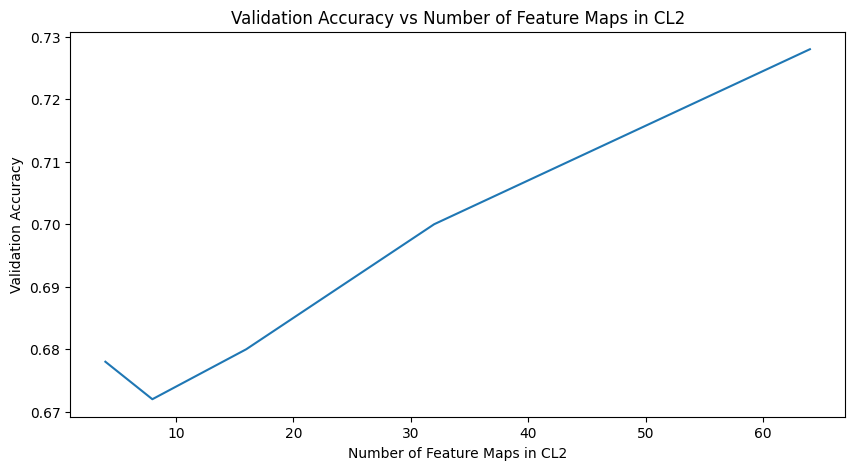

In [ ]:
# Hyperparameter tuning for the number of feature maps in CL2
# Use the validation dataset to tune the hyperparameter
# Plot the validation accuracy vs the number of feature maps in CL2
# Choose the hyperparameter that gives the best validation accuracy

cl2_feature_maps = [4, 8, 16, 32, 64]
valid_accuracies = []
for cl2 in cl2_feature_maps:
    model = CNN(cl2, len(train_dataset.classes)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    image_classification = ImageClassification(model, criterion, optimizer)
    image_classification.train(train_loader, valid_loader, num_epochs=5)
    valid_accuracies.append(image_classification.valid_accuracies[-1])

plt.figure(figsize=(10, 5))
plt.plot(cl2_feature_maps, valid_accuracies)
plt.xlabel('Number of Feature Maps in CL2')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs Number of Feature Maps in CL2')
plt.savefig('plots/Q2/hyperparameter_tuning.pdf', format='pdf', bbox_inches='tight')
plt.show()


Epoch 1/10: 100%|██████████| 63/63 [00:11<00:00,  5.54batch/s, Running Loss=1.64]


Epoch 1/10, Train Loss: 1.6355, Train Accuracy: 0.4970
Epoch 1/10, Valid Loss: 0.9411, Valid Accuracy: 0.6500


Epoch 2/10: 100%|██████████| 63/63 [00:10<00:00,  5.91batch/s, Running Loss=0.727]


Epoch 2/10, Train Loss: 0.7274, Train Accuracy: 0.7270
Epoch 2/10, Valid Loss: 0.8418, Valid Accuracy: 0.6860


Epoch 3/10: 100%|██████████| 63/63 [00:10<00:00,  6.17batch/s, Running Loss=0.485]


Epoch 3/10, Train Loss: 0.4846, Train Accuracy: 0.8445
Epoch 3/10, Valid Loss: 0.8280, Valid Accuracy: 0.7020


Epoch 4/10: 100%|██████████| 63/63 [00:05<00:00, 10.61batch/s, Running Loss=0.299]


Epoch 4/10, Train Loss: 0.2988, Train Accuracy: 0.9115
Epoch 4/10, Valid Loss: 0.8486, Valid Accuracy: 0.7080


Epoch 5/10: 100%|██████████| 63/63 [00:06<00:00, 10.05batch/s, Running Loss=0.178]


Epoch 5/10, Train Loss: 0.1785, Train Accuracy: 0.9520
Epoch 5/10, Valid Loss: 1.0694, Valid Accuracy: 0.6780


Epoch 6/10: 100%|██████████| 63/63 [00:05<00:00, 11.85batch/s, Running Loss=0.105]


Epoch 6/10, Train Loss: 0.1052, Train Accuracy: 0.9785
Epoch 6/10, Valid Loss: 1.0096, Valid Accuracy: 0.6900


Epoch 7/10: 100%|██████████| 63/63 [00:05<00:00, 11.46batch/s, Running Loss=0.054]


Epoch 7/10, Train Loss: 0.0540, Train Accuracy: 0.9910
Epoch 7/10, Valid Loss: 1.1688, Valid Accuracy: 0.6700


Epoch 8/10: 100%|██████████| 63/63 [00:05<00:00, 11.60batch/s, Running Loss=0.0272]


Epoch 8/10, Train Loss: 0.0272, Train Accuracy: 0.9975
Epoch 8/10, Valid Loss: 1.2117, Valid Accuracy: 0.6800


Epoch 9/10: 100%|██████████| 63/63 [00:05<00:00, 11.85batch/s, Running Loss=0.0148]


Epoch 9/10, Train Loss: 0.0148, Train Accuracy: 0.9990
Epoch 9/10, Valid Loss: 1.2778, Valid Accuracy: 0.6900


Epoch 10/10: 100%|██████████| 63/63 [00:05<00:00, 11.33batch/s, Running Loss=0.00945]


Epoch 10/10, Train Loss: 0.0095, Train Accuracy: 1.0000
Epoch 10/10, Valid Loss: 1.3104, Valid Accuracy: 0.6680
Test Loss: 1.3435, Test Accuracy: 0.6720


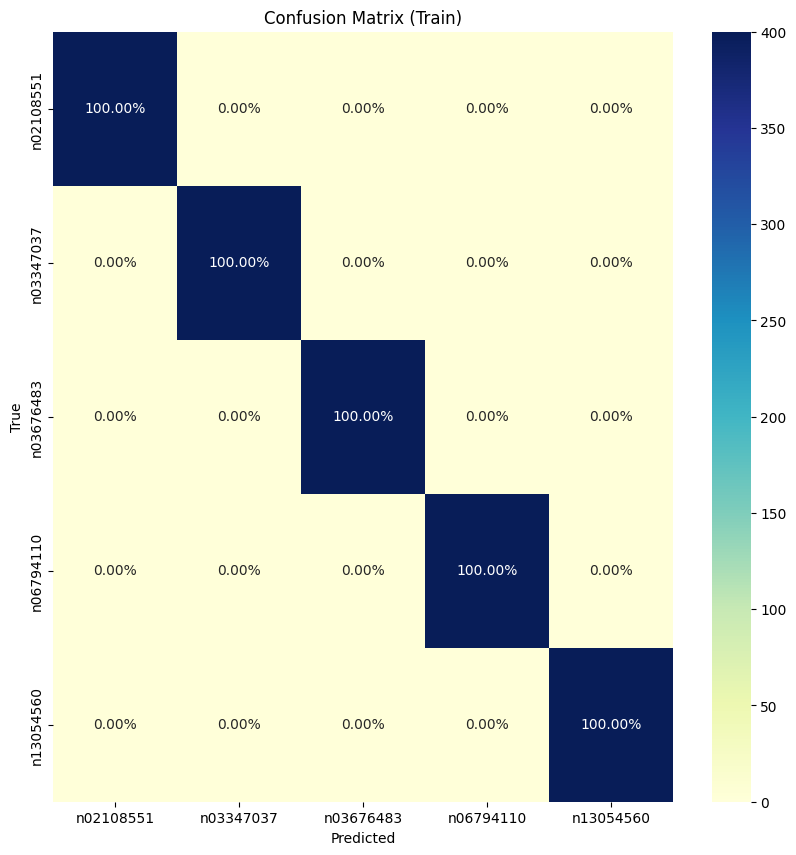

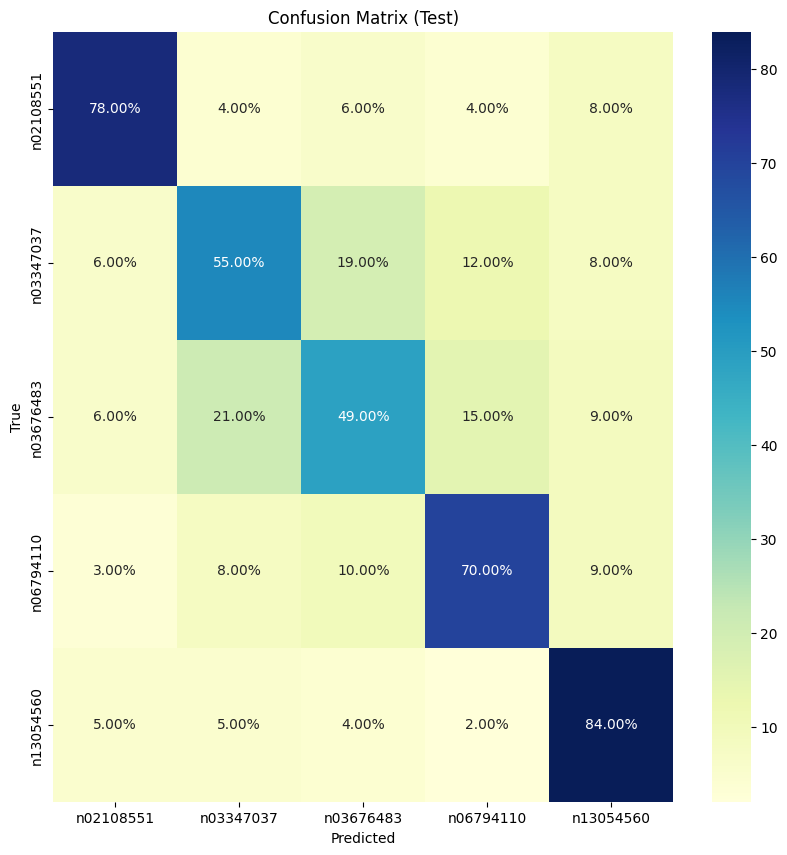

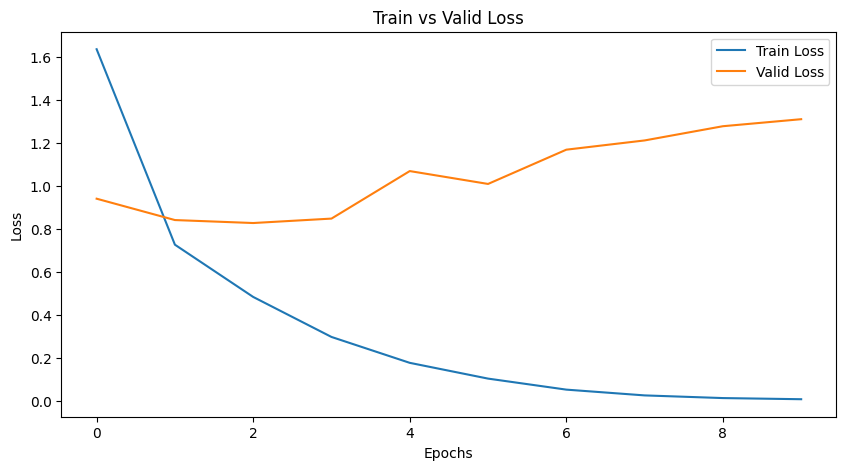

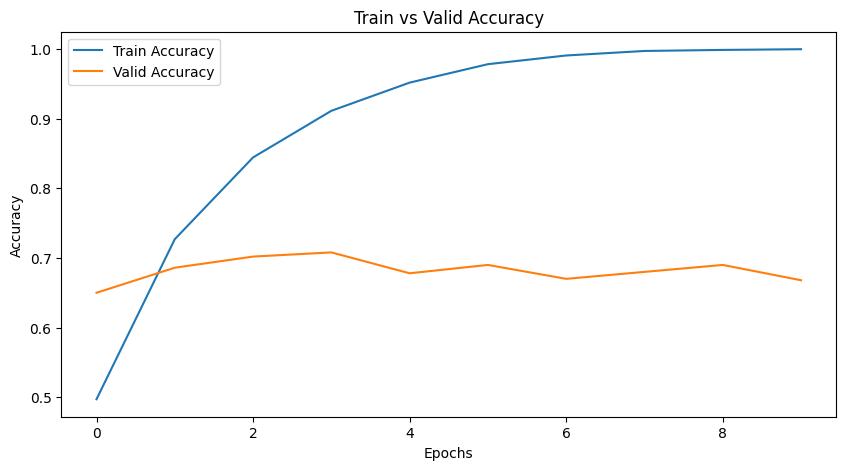

In [12]:
# 8 didnt train well, 32 overfitted
cl2_feature_maps = 16
num_classes = len(train_dataset.classes) # = 5

# Initialize the model, loss function, and optimizer
model = CNN(cl2_feature_maps, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

image_classification = ImageClassification(model, criterion, optimizer)
image_classification.train(train_loader, valid_loader, num_epochs=10)
image_classification.test(test_loader)

# Plot confusion matrix, losses, and accuracies
image_classification.plot_cm_train(train_loader)
image_classification.plot_cm_test(test_loader)
image_classification.plot_losses()
image_classification.plot_accuracies()
